In [1]:
import pandas as pd
import numpy as np
import os, random, glob, re

# Visualization
%matplotlib inline
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams['axes.unicode_minus'] = False
sns.set(style='whitegrid', palette='muted', font_scale=1.5)
plt.rc('font', family='Malgun Gothic')

# Modeling
from scipy.sparse.linalg import svds
from sklearn.metrics import mean_squared_error

# Warnings
import warnings
warnings.filterwarnings('always')
warnings.filterwarnings('ignore')

# Reference data
MovieLens 100K Dataset <br>
[[Data Description]](https://files.grouplens.org/datasets/movielens/ml-100k-README.txt)

In [2]:
filepath = './data/ml-100k'

In [3]:
# # user
# u_user = pd.read_csv(os.path.join(filepath, "u.user"), sep="|", encoding="iso-8859-1", header=None)
# u_user.columns = 'user id | age | gender | occupation | zip code'.replace(" ","").split("|")

# movie data
u_item = pd.read_csv(os.path.join(filepath, "u.item"), sep="|", encoding="iso-8859-1", header=None)
st = '''movie id | movie title | release date | video release date |
              IMDb URL | unknown | Action | Adventure | Animation |
              Children's | Comedy | Crime | Documentary | Drama | Fantasy |
              Film-Noir | Horror | Musical | Mystery | Romance | Sci-Fi |
              Thriller | War | Western |'''
st = re.sub(r' +', "", st).replace('\n','').split("|")[:-1]
u_item.columns = st

# rating data
u_data = pd.read_csv(os.path.join(filepath, "u.data"), sep="\t", encoding="iso-8859-1", header=None)
u_data.columns = 'user id | item id | rating | timestamp'.replace(" ","").split("|")
u_data.head()

,userid,itemid,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


# Load the data

In [4]:
# 943 users X 1682 items(movies)
pivot_data = u_data.iloc[:,:3].pivot_table(index='userid', columns="itemid",values='rating',aggfunc='first')
pivot_data.head()

itemid,1,2,3,4,5,6,7,8,9,10,...,1673,1674,1675,1676,1677,1678,1679,1680,1681,1682
userid,,,,,,,,,,,,,,,,,,,,,
1,5.0,3.0,4.0,3.0,3.0,5.0,4.0,1.0,5.0,3.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,4.0,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
min(pivot_data) # There's no 0 values

1

In [6]:
mtx = np.array(pivot_data.fillna(0))
print(f"sparsity: {round(np.count_nonzero(mtx)/np.prod(mtx.shape)*100, 3)}(%)")

sparsity: 6.305(%)


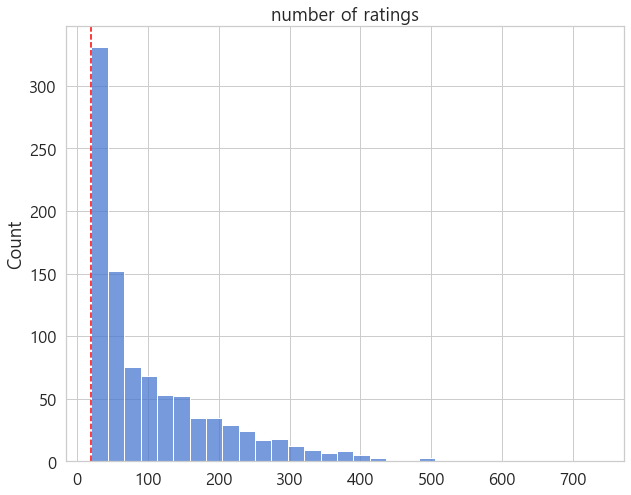

In [7]:
fig, ax = plt.subplots(figsize=(10,8))
sns.histplot(np.sum(mtx!=0, axis=1)).set_title("number of ratings")
plt.axvline(x=20, color="red",linestyle="--")
plt.show()

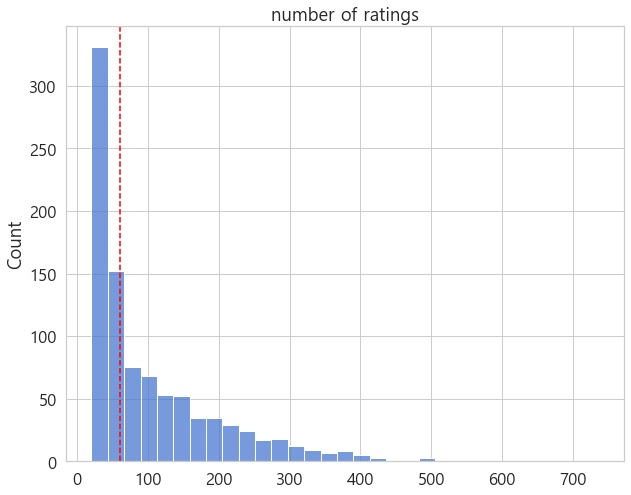

In [305]:
fig, ax = plt.subplots(figsize=(10,8))
sns.histplot(np.sum(mtx!=0, axis=1)).set_title("number of ratings")
plt.axvline(x=60, color="red",linestyle="--")
plt.show()

# MF by SVD

In [8]:
def MF(pivot_data, k):
    # Center the data
    user_item = pivot_data.fillna(0)
    user_mean = np.array(user_item.mean(axis=1)) # User average ratings
    user_item_centering = pd.DataFrame(np.array(user_item)-user_mean.reshape(-1,1))
    user_item_centering.head()

    # Truncated SVD
    U, D, V = svds(user_item_centering, k=k)
    D = np.diag(D)

    # prediction
    user_item_pred = pd.DataFrame(U@D@V+user_mean.reshape(-1,1)).set_index(user_item.index).set_axis(user_item.columns, axis=1)
    return user_item_pred

# Return top-n movies

In [10]:
def get_genre(u_item, idx):
    genre = u_item[u_item.movieid.isin(idx)].iloc[:,5:]
    tmp = genre.apply(lambda x: genre.columns[np.where(x==1)].tolist(), axis=1)
    return tmp

def Top_n(user, top, pred, df_item, idx): 
    top_n = pd.DataFrame(pred.loc[user][idx].nlargest(top)).set_axis(['ratings'], axis=1)
    rec = df_item[df_item.movieid.isin(top_n.index)][['movieid','movietitle','releasedate']]
    rec['genre'] = pd.DataFrame(get_genre(df_item, top_n.index))
    rec = pd.merge(rec.set_index('movieid'), top_n, left_index=True, right_index=True, how="inner").sort_values('ratings', ascending=False).reset_index()
    return rec.rename(columns={'index':'movieid'})

In [11]:
# Prediction
k = 50
user_item_pred = MF(pivot_data, k)

# Result
user = 1
top = 20
not_seen = pivot_data.loc[user][pivot_data.loc[user].isna()].index
seen = pivot_data.loc[user][~pivot_data.loc[user].isna()].index
result = Top_n(user, top, user_item_pred, u_item, not_seen)
result

,movieid,movietitle,releasedate,genre,ratings
0,423,E.T. the Extra-Terrestrial (1982),01-Jan-1982,"[Children's, Drama, Fantasy, Sci-Fi]",3.509642
1,403,Batman (1989),01-Jan-1989,"[Action, Adventure, Crime, Drama]",3.097894
2,732,Dave (1993),01-Jan-1993,"[Comedy, Romance]",2.971226
3,357,One Flew Over the Cuckoo's Nest (1975),01-Jan-1975,[Drama],2.752628
4,385,True Lies (1994),01-Jan-1994,"[Action, Adventure, Comedy, Romance]",2.605706
5,303,Ulee's Gold (1997),01-Jan-1997,[Drama],2.574760
6,470,Tombstone (1993),01-Jan-1993,[Western],2.475011
7,367,Clueless (1995),01-Jan-1995,[Comedy],2.432600
8,582,"Piano, The (1993)",01-Jan-1993,"[Drama, Romance]",2.409058
9,318,Schindler's List (1993),01-Jan-1993,"[Drama, War]",2.376752


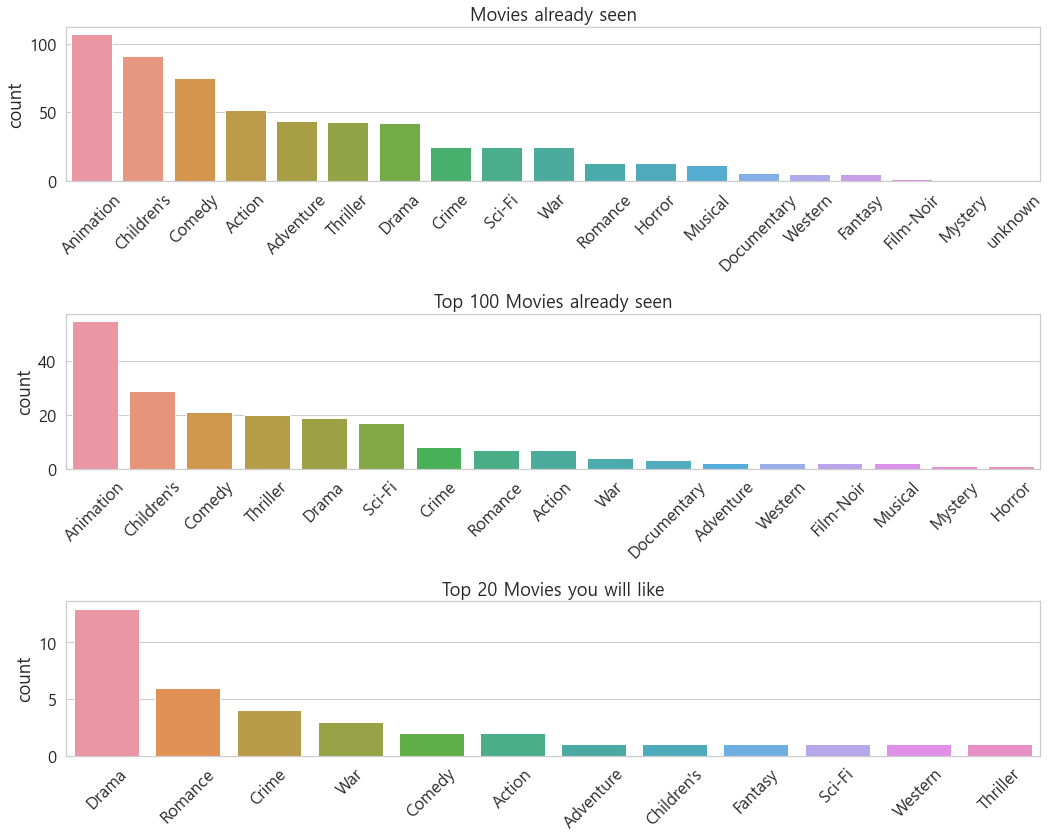

In [12]:
# movies already seen
tmp = get_genre(u_item, seen).explode()

# select top n 
n = 100
top_n = pd.DataFrame(pivot_data.fillna(0).loc[user][seen].nlargest(n)).index
tmp2 = get_genre(u_item, top_n).explode()
tmp3 = get_genre(u_item, result.movieid).explode()

# plot
fig, ax = plt.subplots(figsize=(15,12), nrows=3)
sns.countplot(tmp, order=tmp.value_counts().index, ax=ax[0]).set_title("Movies already seen")
sns.countplot(tmp2, order=tmp2.value_counts().index, ax=ax[1]).set_title(f"Top {n} Movies already seen")
sns.countplot(tmp3, order=tmp3.value_counts().index, ax=ax[2]).set_title(f"Top {top} Movies you will like")
ax[0].set_xticklabels(tmp.unique(), rotation=45)
ax[1].set_xticklabels(tmp2.unique(), rotation=45)
ax[2].set_xticklabels(tmp3.unique(), rotation=45)
plt.tight_layout()
plt.show()

# MF by ALS

In [201]:
def create_train_test(ratings, size=10):
    """
    split into training and test sets,
    remove 10 ratings from each user
    and assign them to the test set
    """
    test = np.zeros(ratings.shape)
    train = ratings.copy()
    for user in range(ratings.shape[0]):
        test_index = np.random.choice(
            np.flatnonzero(ratings[user]), size = size, replace = False)

        train[user, test_index] = 0.0
        test[user, test_index] = ratings[user, test_index]
        
    # assert that training and testing set are truly disjoint
    assert np.all(train * test == 0)
    return train, test

class ExplicitMF:
    """
    Train a matrix factorization model using Alternating Least Squares
    to predict empty entries in a matrix
    
    Parameters
    ----------
    n_iters : int
        number of iterations to train the algorithm
        
    n_factors : int
        number of latent factors to use in matrix 
        factorization model, some machine-learning libraries
        denote this as rank
        
    reg : float
        regularization term for item/user latent factors,
        since lambda is a keyword in python we use reg instead
    """

    def __init__(self, n_iters, n_factors, reg):
        self.reg = reg
        self.n_iters = n_iters
        self.n_factors = n_factors  
        
    def fit(self, train, test):
        """
        pass in training and testing at the same time to record
        model convergence, assuming both dataset is in the form
        of User x Item matrix with cells as ratings
        """
        self.n_user, self.n_item = train.shape
        self.user_factors = np.random.random((self.n_user, self.n_factors))
        self.item_factors = np.random.random((self.n_item, self.n_factors))
        
        # record the training and testing mse for every iteration
        # to show convergence later (usually, not worth it for production)
        self.test_mse_record  = []
        self.train_mse_record = []   
        for _ in range(self.n_iters):
            self.user_factors = self._als_step(train, self.user_factors, self.item_factors)
            self.item_factors = self._als_step(train.T, self.item_factors, self.user_factors) 
            predictions = self.predict()
            test_mse = self.compute_mse(test, predictions)
            train_mse = self.compute_mse(train, predictions)
            self.test_mse_record.append(test_mse)
            self.train_mse_record.append(train_mse)
        self.predictions = predictions
        return self  
    
    def _als_step(self, ratings, solve_vecs, fixed_vecs):
        """
        when updating the user matrix,
        the item matrix is the fixed vector and vice versa
        """
        A = fixed_vecs.T.dot(fixed_vecs) + np.eye(self.n_factors) * self.reg
        b = ratings.dot(fixed_vecs)
        A_inv = np.linalg.inv(A)
        solve_vecs = b.dot(A_inv)
        return solve_vecs
    
    def predict(self):
        """predict ratings for every user and item"""
        pred = self.user_factors.dot(self.item_factors.T)
        return pred
    
    @staticmethod
    def compute_mse(y_true, y_pred):
        """ignore zero terms prior to comparing the mse"""
        mask = np.nonzero(y_true)
        mse = mean_squared_error(y_true[mask], y_pred[mask])
        return mse
    
def plot_learning_curve(model):
    """visualize the training/testing loss"""
    linewidth = 3
    plt.plot(model.test_mse_record, label = 'Test', linewidth = linewidth)
    plt.plot(model.train_mse_record, label = 'Train', linewidth = linewidth)
    plt.xlabel('iterations')
    plt.ylabel('MSE')
    plt.legend(loc = 'best')

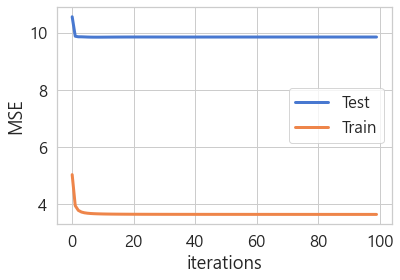

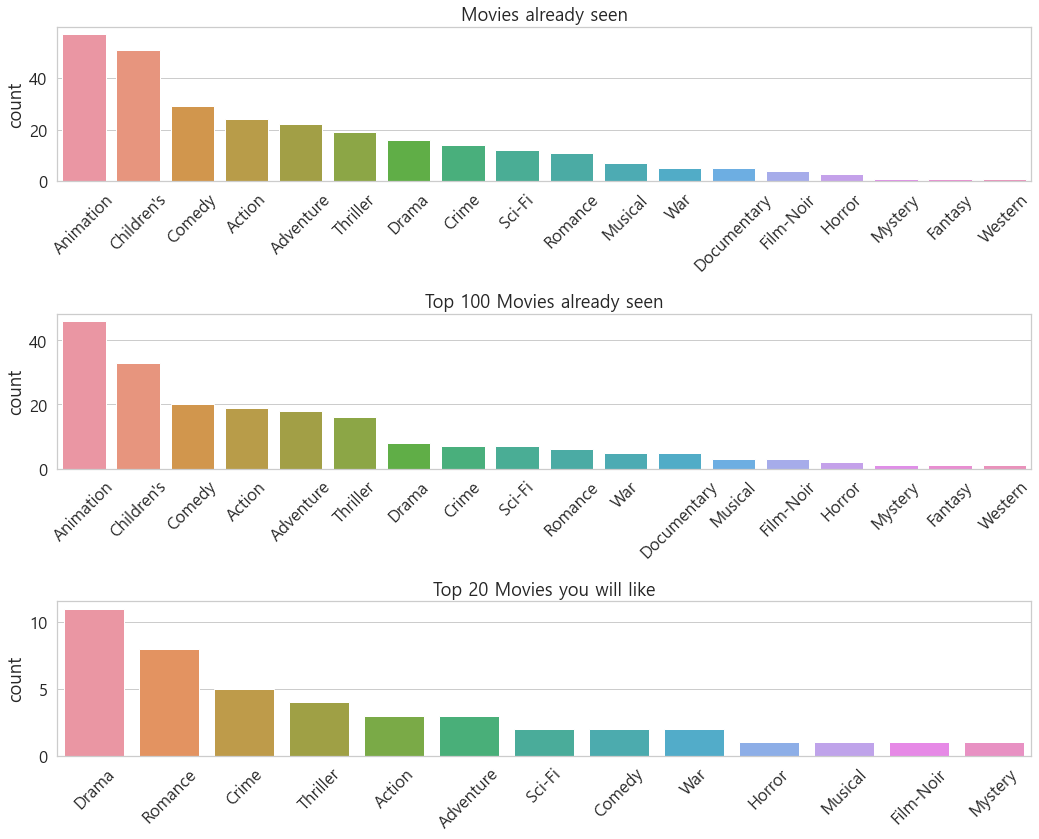

In [202]:
# Prediction
mtx = np.array(pivot_data.fillna(0))
train, test = create_train_test(mtx, 20)
als = ExplicitMF(n_iters = 100, n_factors = 50, reg = 0.01)
als.fit(train, test)
plot_learning_curve(als)
user_item_pred = pd.DataFrame(als.predictions).set_axis(pivot_data.columns, axis=1)

# Result
user = 1
top = 20
not_seen = pivot_data.loc[user][pivot_data.loc[user].isna()].index
result = Top_n(user, top, user_item_pred, u_item, not_seen)

# movies already seen
tmp = get_genre(u_item, seen).explode()

# select top n 
n = 100
top_n = pd.DataFrame(pivot_data.fillna(0).loc[user][seen].nlargest(n)).index
tmp2 = get_genre(u_item, top_n).explode()
tmp3 = get_genre(u_item, result.movieid).explode()

# plot
fig, ax = plt.subplots(figsize=(15,12), nrows=3)
sns.countplot(tmp, order=tmp.value_counts().index, ax=ax[0]).set_title("Movies already seen")
sns.countplot(tmp2, order=tmp2.value_counts().index, ax=ax[1]).set_title(f"Top {n} Movies already seen")
sns.countplot(tmp3, order=tmp3.value_counts().index, ax=ax[2]).set_title(f"Top {top} Movies you will like")
ax[0].set_xticklabels(tmp.unique(), rotation=45)
ax[1].set_xticklabels(tmp2.unique(), rotation=45)
ax[2].set_xticklabels(tmp3.unique(), rotation=45)
plt.tight_layout()
plt.show()

In [206]:
user = 1
not_seen = pivot_data.loc[user][pivot_data.loc[user].isna()].index


Int64Index([ 273,  274,  275,  276,  277,  278,  279,  280,  281,  282,
            ...
            1673, 1674, 1675, 1676, 1677, 1678, 1679, 1680, 1681, 1682],
           dtype='int64', name='itemid', length=1410)

In [218]:
user_item_pred

itemid,1,2,3,4,5,6,7,8,9,10,...,1673,1674,1675,1676,1677,1678,1679,1680,1681,1682
0,6.785837,2.810317,1.156944,3.682832,2.056254,1.349007,3.440817,1.025621,1.812044,1.974621,...,-0.001869,0.000897,-0.042018,-0.028012,0.062042,0.002338,0.007014,0.0,0.011845,0.072712
1,2.436592,-0.396096,-0.107817,-0.112682,0.043086,0.334859,0.721121,0.119486,0.862869,0.747814,...,-0.011556,-0.024401,-0.019835,-0.013224,0.003075,0.002350,0.007050,0.0,0.000136,0.014286
2,0.169371,-0.069751,-0.103844,-0.239295,0.024679,-0.027986,0.098867,0.150545,-0.037565,0.335227,...,0.010609,-0.014565,0.036576,0.024384,-0.005351,0.016802,0.050407,0.0,0.010576,-0.018862
3,-0.048763,-0.001873,0.026981,0.037127,0.003079,-0.063529,-0.060841,-0.006241,0.089533,-0.052875,...,0.003131,0.002537,0.007041,0.004694,0.003334,0.002413,0.007239,0.0,-0.001701,-0.009720
4,3.360300,1.312671,0.086261,0.888032,0.054704,-0.184078,2.294841,0.301624,-0.370143,0.434483,...,-0.004494,-0.077219,-0.028667,-0.019112,-0.049110,-0.001233,-0.003698,0.0,-0.040571,-0.022418
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
938,1.414827,-0.303815,-0.014417,0.019302,0.208114,-0.021547,0.414603,0.206401,0.556014,-0.166773,...,0.011370,-0.010478,0.013297,0.008865,0.008417,-0.003221,-0.009664,0.0,-0.014656,0.001024
939,0.022307,-0.302760,-0.246875,2.346512,0.582174,0.043918,3.022673,1.788073,1.569656,-0.566580,...,0.032579,0.026322,0.008543,0.005695,0.006489,0.011141,0.033423,0.0,0.001698,-0.092776
940,0.051037,-0.023426,0.010708,-0.001738,-0.045490,-0.001309,0.100837,0.049384,-0.068159,0.049348,...,-0.001654,-0.008905,0.002953,0.001969,0.000389,-0.000036,-0.000109,0.0,0.001905,-0.002673
941,-0.014545,0.550778,-0.066711,0.029752,-0.167899,0.025167,-1.061027,1.584203,-0.075446,-0.257541,...,-0.002216,0.025743,0.060961,0.040640,-0.000784,0.006445,0.019336,0.0,0.016240,0.015419


In [ ]:
from sklearn.metrics import ndcg_score
true = 
score = 
ndcg_score(true, scores)

In [227]:
not_seen

Int64Index([ 273,  274,  275,  276,  277,  278,  279,  280,  281,  282,
            ...
            1673, 1674, 1675, 1676, 1677, 1678, 1679, 1680, 1681, 1682],
           dtype='int64', name='itemid', length=1410)

In [224]:
user_item_pred.iloc[0]

itemid
1       6.785837
2       2.810317
3       1.156944
4       3.682832
5       2.056254
          ...   
1678    0.002338
1679    0.007014
1680    0.000000
1681    0.011845
1682    0.072712
Name: 0, Length: 1682, dtype: float64

In [15]:
print(max(als.predictions.flatten()))
print(min(als.predictions.flatten()))

8.626931242980431
-4.401138164017973


# Evaluation

base 이용해서 train-> base를 predict 상위 x개를 뽑아 ->ndcg, recall, precision 계산 <br>
user별로 다름-> user마다 rating갯수가 다르다->full data 로 확인해서 계산=x

In [299]:
# u_data의 일부 user들의 일부 rating을 test로 분리
u_base = pd.read_csv(os.path.join(filepath, "ua.base"), sep="\t", encoding="iso-8859-1", header=None)
u_base.columns = 'user id | item id | rating | timestamp'.replace(" ","").split("|")
u_test = pd.read_csv(os.path.join(filepath, "ua.test"), sep="\t", encoding="iso-8859-1", header=None)
u_test.columns = 'user id | item id | rating | timestamp'.replace(" ","").split("|")

pivot_data = u_data.iloc[:,:3].pivot_table(index='userid', columns="itemid",values='rating',aggfunc='first')
pivot_train = u_base.iloc[:,:3].pivot_table(index='userid', columns="itemid",values='rating',aggfunc='first')
a = np.empty((943,1))
a[:] = np.nan
pivot_train[1582]=pd.DataFrame(a)
pivot_train[1653]=pd.DataFrame(a)
pivot_test = u_test.iloc[:,:3].pivot_table(index='userid', columns="itemid",values='rating',aggfunc='first')
pivot_test[1582]=pd.DataFrame(a)
pivot_test[1653]=pd.DataFrame(a)

In [ ]:
pivot_train

In [266]:
# Ex) 440번 user의 51개 raing 중에서 10개를 test에 할당
print(f"# of Total Ratings: {np.flatnonzero(pivot_data.fillna(0).loc[440]).shape}")
print(f"test data: {set(u_test[u_test.userid==440].itemid)-set(u_base[u_base.userid==440].itemid)}")

# of Total Ratings: (51,)
test data: {512, 1504, 323, 515, 1038, 751, 1073, 690, 886, 283}


In [297]:
print(f"# of Total Ratings: {np.flatnonzero(pivot_data.fillna(0).loc[1]).shape}")
print(f"test data: {set(u_test[u_test.userid==1].itemid)-set(u_base[u_base.userid==1].itemid)}")

# of Total Ratings: (272,)
test data: {160, 33, 265, 202, 171, 61, 20, 117, 155, 189}


In [300]:
tmp = pd.concat([u_base, u_test]).iloc[:,:3]
train = np.array(pivot_data.fillna(0))
test = np.array(tmp.pivot_table(index='userid', columns="itemid",values='rating',aggfunc='first').fillna(0))
train.shape, test.shape

((943, 1682), (943, 1682))

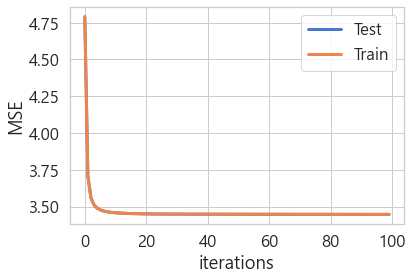

In [263]:
# Prediction
als = ExplicitMF(n_iters = 100, n_factors = 50, reg = 0.01)
als.fit(train, test)
plot_learning_curve(als)
user_item_pred = pd.DataFrame(als.predictions).set_axis(pivot_data.columns, axis=1)

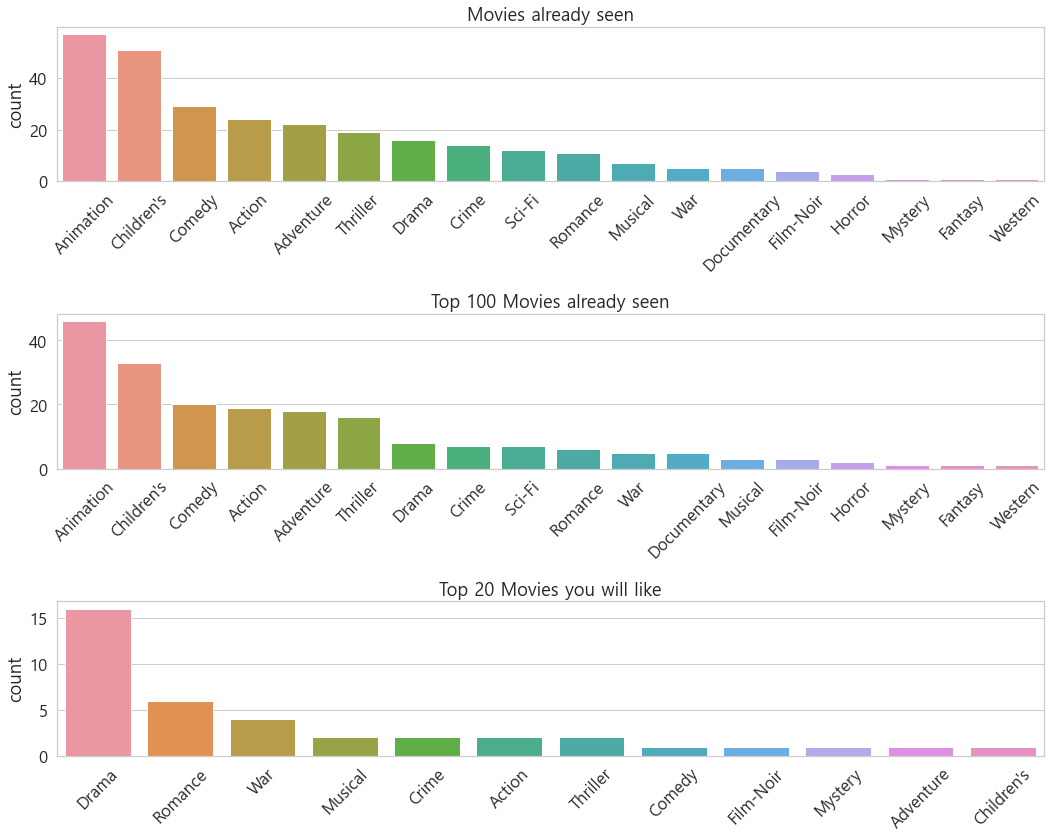

In [250]:
# Result
user = 1
top = 20
result = Top_n(user, top, user_item_pred, u_item, not_seen)

# movies already seen
tmp = get_genre(u_item, seen).explode()

# select top n 
n = 100
top_n = pd.DataFrame(pivot_data.fillna(0).loc[user][seen].nlargest(n)).index
tmp2 = get_genre(u_item, top_n).explode()
tmp3 = get_genre(u_item, result.movieid).explode()

# plot
fig, ax = plt.subplots(figsize=(15,12), nrows=3)
sns.countplot(tmp, order=tmp.value_counts().index, ax=ax[0]).set_title("Movies already seen")
sns.countplot(tmp2, order=tmp2.value_counts().index, ax=ax[1]).set_title(f"Top {n} Movies already seen")
sns.countplot(tmp3, order=tmp3.value_counts().index, ax=ax[2]).set_title(f"Top {top} Movies you will like")
ax[0].set_xticklabels(tmp.unique(), rotation=45)
ax[1].set_xticklabels(tmp2.unique(), rotation=45)
ax[2].set_xticklabels(tmp3.unique(), rotation=45)
plt.tight_layout()
plt.show()